In [26]:
library("httr")
library("jsonlite")
library('dplyr', warn.conflicts = FALSE)

In [27]:
# prepare urls
base <- "http://mediamonitoring.gesis.org/api/organizations/"
base_pol <- "http://mediamonitoring.gesis.org/api/politicians/"
url_all <- paste(base,"all/", sep="")
url_tweets <- paste(base, "twitter/tweets_by/organizations/", sep="")
url_replies <- paste(base, "twitter/replies_to/organizations/", sep="")
url_tweets_gen <- paste(base_pol,"twitter/general_population/?", sep="")

In [28]:
# prepare parameters
params = list(
    from_date='2017-01-01',
    to_date='2019-12-31',
    aggregate_by='month'
)


In [4]:
# use the api to get the organizations and filter the orgs
orgs <- as.data.frame(fromJSON(content(GET(url_all), "text", encoding="UTF-8"), flatten = TRUE))
media <- orgs[orgs$category == "media"  & !is.null(orgs$tw_ids),]$organization_id
political <- orgs[orgs$category == "political"  & !is.null(orgs$tw_ids),]$organization_id

# Alle Tweets

In [5]:
# Retrieve the tweets for each type

# Prepare data frames for each type of org
tweets_media <- data.frame()
tweets_political <- data.frame()

# Get tweets from media
for (organization_id in media) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_media <- rbind(tweets_media, as.data.frame(json_tweets))        
    }
}
tweets_media[['type']] <- "media"

# Get tweets from political
for (organization_id in political) {
    json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
    if (length(json_tweets$values) != 0) {
        tweets_political <- rbind(tweets_political, as.data.frame(json_tweets))        
    }
}
tweets_political[['type']] <- "political"


In [6]:
## concatenate
all <- rbind(tweets_media, tweets_political)

In [7]:
# Alternative code to the previous one: more compact but harder to follow

## Create vector to store the names of the party and their corresponding organizations
#test <- vector(mode="list", length=2)
#names(test) <- c("media", "political")
#test[[1]] <- media
#test[[2]] <- political
#
#all <- data.frame()
#for (name in names(test)) {
#    org_df <- data.frame()
#    for (organization_id in test[[name]]) {
#        json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
#        if (length(json_tweets$values) != 0) {
#            org_df <- rbind(org_df, as.data.frame(json_tweets))        
#        }
#    }
#    org_df[['type']] <- name
#    all <- rbind(all, org_df)
#}

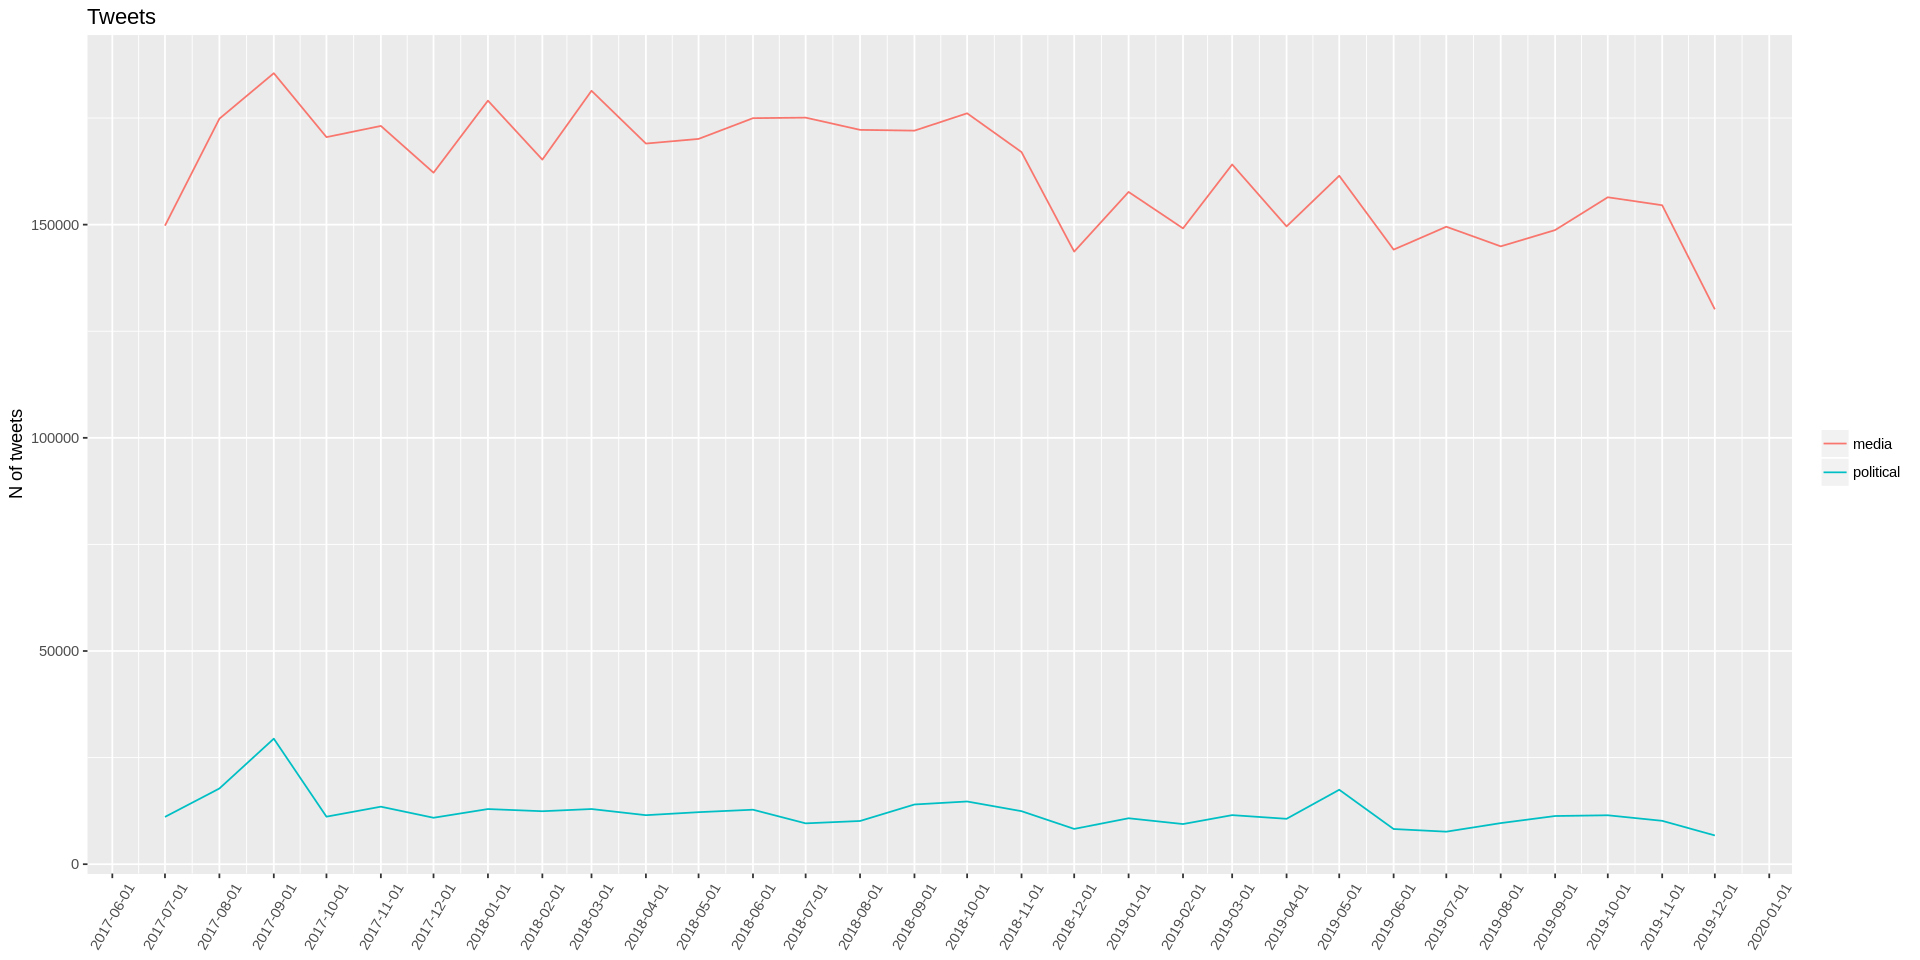

In [8]:
library("ggplot2")
options(repr.plot.width=16, repr.plot.height=8)

# plotting tweets 
ggplot(data=all, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets", y = "N of tweets") +
    scale_x_date(date_breaks = "1 month") 

In [9]:
tweets_gen = as.data.frame(fromJSON(content(GET(url_tweets_gen,query=params), "text", encoding="UTF-8"), flatten = TRUE))

Warning message:
“Removed 4 rows containing non-finite values (stat_summary).”


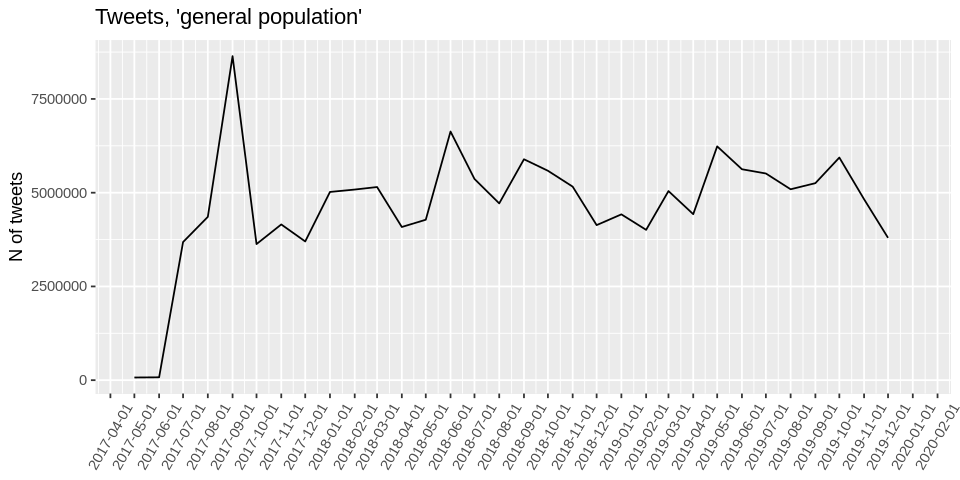

In [11]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot(data=tweets_gen, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line") +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets, 'general population'", y = "N of tweets") +
    scale_x_date(limits = as.Date(c("2017-05-01", params$to_date)), date_breaks = "1 month") 

# Tweets mit Migration

In [13]:
migration <- paste(readLines("Migration.txt"))

In [16]:
url_tweets_topics <- paste(base, "twitter/tweets_by/organizations", sep="")
url_tweets_pol <- paste(base_pol,"twitter/tweets_by/politicians", sep="")

params = list(
    from_date='2017-01-01',
    to_date='2019-12-31',
    aggregate_by='month',
    text_contains=migration
)

In [17]:
# Reusing 

# Alternative code to the previous one: more compact but harder to follow

# Create vector to store the names of the party and their corresponding organizations
test <- vector(mode="list", length=2)
names(test) <- c("Media", "Political Org")
test[[1]] <- media
test[[2]] <- political

all <- data.frame()
for (name in names(test)) {
    org_df <- data.frame()
    for (organization_id in test[[name]]) {
        json_tweets <- fromJSON(content(GET(paste(url_tweets, organization_id, "/?", sep=""),query=params), "text", encoding="UTF-8"), flatten = TRUE)
        if (length(json_tweets$values) != 0) {
            org_df <- rbind(org_df, as.data.frame(json_tweets))        
        }
    }
    org_df[['Type']] <- name
    
    all <- rbind(all, org_df)
}

tweets_pol = as.data.frame(fromJSON(content(GET(url_tweets_pol, query=params), "text", encoding="UTF-8"), flatten = TRUE))
tweets_gen = as.data.frame(fromJSON(content(GET(url_tweets_gen, query=params), "text", encoding="UTF-8"), flatten = TRUE))
tweets_pol[['Type']] <- "Politician"
all_with_pol <- rbind(all, tweets_pol)

In [18]:
#retrieving data for votes in Bundestag and Bundesländer
bundestag <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/bundestag/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)
bavaria <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/bayern%202013-2018/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)
badenw <- as.data.frame(fromJSON(content(GET(paste("https://www.abgeordnetenwatch.de/api/parliament/baden-w%C3%BCrttemberg/polls.json")), "text", encoding="UTF-8"), flatten = TRUE)$polls)

In [19]:
migration_keywords <- as.list(strsplit(migration, '\\|')[[1]])

retrieve_bills <- function(votes, regex) {
    bills <- data.frame()
    bills <- votes[ which(grepl(pattern = regex, bundestag$summary)),]
    return(bills)
    }

retrieve_dates <- function(votes, migration_keywords) {
    dates = list()
    for (word in migration_keywords) {
        migration_df <- votes[ which(grepl(word, votes$meta.topics, fixed=TRUE) | grepl(word, votes$title, fixed=TRUE) | grepl(word, votes$summary, fixed=TRUE)), ]
        
        #FILTERING WITH A REGEX:
        
        for (date in migration_df$date)
            dates[[ (length(dates) + 1) ]] <-date
        }
    return(unique(dates))
    }

#retrieving the dates of bills with certain topic
dates_bundestag <- retrieve_dates(bundestag, migration_keywords)
dates_bavaria <- retrieve_dates(bavaria, migration_keywords)
dates_badenw <- retrieve_dates(badenw, migration_keywords)

In [20]:
#retrieving the bills with a regex
retrieve_bills(bundestag, "AfD-Antrag")

,title,date,summary,status,meta.uuid,meta.edited,meta.topics,meta.url,meta.datasets.poll.by-name,meta.datasets.poll.by-uuid,⋯,stats.FDP.dagegen gestimmt,stats.FDP.enthalten,stats.fraktionslos.dafür gestimmt,stats.fraktionslos.dagegen gestimmt,stats.fraktionslos.nicht beteiligt,stats.fraktionslos.enthalten,stats.SPD.dafür gestimmt,stats.SPD.nicht beteiligt,stats.SPD.dagegen gestimmt,stats.SPD.enthalten
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,Organspenden-Reform: Zustimmungslösung,2020-01-16,"Der Bundestag stimmt über zwei überfraktionell eingebrachte Gesetzesentwürfe ab, welche die Bundesregierung auffordern, dass Organspendemodell in Deutschland zu reformieren. Die Abgeordneten entscheiden über die Einführung einer Widerspruchslösung oder einer Zustimmungslösung. Über die Widerspruchs- und die Zustimmungslösung sowie über einen AfD-Antrag wurde jeweils namentlich abgestimmt. Hier finden Sie die Ergebnisse zur Zustimmungslösung. Mit 432 Ja-Stimmen und 200 Nein-Stimmen wurde der Antrag zur Zustimmungslösung bei 37 Enthaltungen in der dritten Beratung angenommen.",voted,70e52981-c4b6-477a-a74b-6563e945d968,2020-01-16 15:00,"Gesellschaftspolitik, soziale Gruppen, Gesundheit",https://www.abgeordnetenwatch.de/bundestag/abstimmungen/organspenden-reform-zustimmungsloesung,https://www.abgeordnetenwatch.de/api/parliament/bundestag/poll/organspenden-reform%3A%20zustimmungsl%C3%B6sung/poll.json,https://www.abgeordnetenwatch.de/api/parliament/60d0787f-e311-4283-a7fd-85b9f62a9b33/poll/70e52981-c4b6-477a-a74b-6563e945d968/poll.json,⋯,3,2,3,1,1,NA,68,11,71,2
3,Organspenden-Reform: Widerspruchslösung,2020-01-16,"Der Bundestag stimmt über zwei überfraktionell eingebrachte Gesetzesentwürfe ab, welche die Bundesregierung auffordern, dass Organspendemodell in Deutschland zu reformieren. Die Abgeordneten entscheiden über die Einführung einer Widerspruchslösung oder einer Zustimmungslösung. Über die Widerspruchs- und die Zustimmungslösung sowie über einen AfD-Antrag wurde jeweils namentlich abgestimmt. Hier finden Sie die Ergebnisse zur Widerspruchslösung. Mit 292 Ja-Stimmen und 379 Nein-Stimmen wurde der Antrag zur Widerspruchslösung bei 3 Enthaltungen abgelehnt. Die Abstimmungsergebnisse zur angenommen Zustimmungslösung finden Sie hier.",unknown,bb42dc2b-ba31-45a6-8b17-05e48b7e00cc,2020-01-16 15:02,"Gesellschaftspolitik, soziale Gruppen, Gesundheit",https://www.abgeordnetenwatch.de/bundestag/abstimmungen/organspenden-reform-widerspruchsloesung,https://www.abgeordnetenwatch.de/api/parliament/bundestag/poll/organspenden-reform%3A%20widerspruchsl%C3%B6sung/poll.json,https://www.abgeordnetenwatch.de/api/parliament/60d0787f-e311-4283-a7fd-85b9f62a9b33/poll/bb42dc2b-ba31-45a6-8b17-05e48b7e00cc/poll.json,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
32,BDS-Bewegung entgegentreten - Antisemitismus bekämpfen,2019-05-17,"Der AfD-Antrag&nbsp;fordert die Bundesregierung auf, die BDS-Bewegung bundesweit,&nbsp;zum Beispiel auf dem Wege des Vereinsrechtes, zu verbieten. Des Weiteren sollen mit der israelischen Regierung Konsultationen zur gemeinsamen Bekämpfung des Antisemitismus initiiert werden. Der Antrag wurde von allen anderen Fraktionen abgelehnt.&nbsp; Der überfraktionelle Antrag von CDU/CSU, SPD, FDP und Bündnis 90/Die Grünen fordert eine Verurteilung der BDS-Kampagne (""Boycott, Divestment and Sanctions""). Organisationen, die sich antisemitisch äußern&nbsp;oder auch das Existenzrecht Israels in Frage stellen, sollen keine unter Bundestagsverwaltung stehende Räumlichkeiten zur Verfügung gestellt bekommen. Der überfraktionelle Antrag wurde in einer geheimen Wahl angenommen. &nbsp;",voted,5fe86905-32ba-43c1-8683-59fbda993e75,2019-06-12 09:31,"Gesellschaftspolitik, soziale Gruppen",https://www.abgeordnetenwatch.de/bundestag/abstimmungen/bds-bewegung-entgegentreten-antisemitismus-bekaempfen,https://www.abgeordnetenwatch.de/api/parliament/bundestag/poll/bds-bewegung%20entgegentreten%20-%

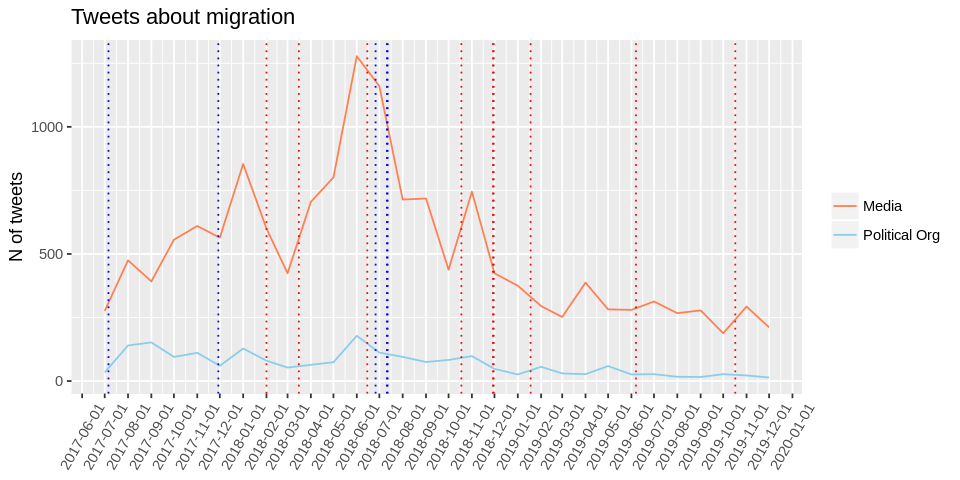

In [22]:
# plotting tweets about migration
lp_0 <- ggplot(data=all, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = Type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets about migration", y = "N of tweets") +
    scale_color_manual(values=c("coral", "skyblue")) +
    scale_x_date(date_breaks = "1 month") 

for (date in unique(dates_bundestag))
    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted",color = "red") 
    #lp_0 <- lp_0 + geom_vline(aes(xintercept = as.Date(date), linetype = "dotted"), colour= 'red') 
for (date in unique(dates_bavaria))
    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "blue") 
for (date in unique(dates_badenw))
    lp_0 <- lp_0 + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "black") 
lp_0

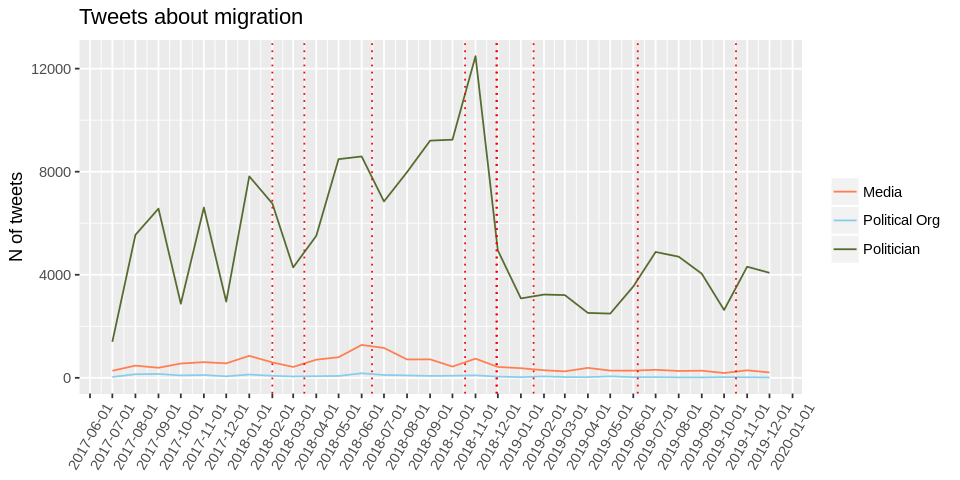

In [23]:
# plotting tweets about migration
lp <- ggplot(data=all_with_pol, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line", aes(colour = Type)) +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets about migration", y = "N of tweets") +
    scale_color_manual(values=c("coral", "skyblue", "darkolivegreen")) +
    scale_x_date(date_breaks = "1 month") 

for (date in unique(dates_bundestag))
    lp <- lp + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "red") 
lp

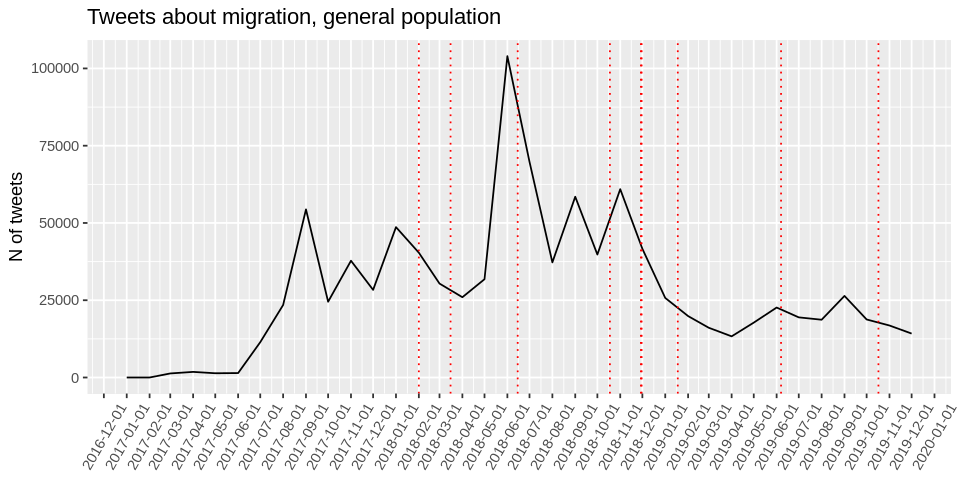

In [25]:
# plotting tweets about migration
lp <- ggplot(data=tweets_gen, aes(x=as.Date(labels), y=values)) + stat_summary(fun.y = sum, geom="line") +

    #geom_point(aes(colour = factor(party))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets about migration, general population", y = "N of tweets") +
    
    scale_x_date(date_breaks = "1 month") 

for (date in unique(dates_bundestag))
    lp <- lp + geom_vline(xintercept = as.Date(date), linetype="dotted", color = "red") 
lp